In [ ]:
# 1.1 Importar bibliotecas essenciais
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay 
from imblearn.over_sampling import SMOTE 
import os 
import numpy as np # Para operações numéricas

# --- Carregamento do Dataset Combinado Diretamente do Kaggle Hub ---
wine_dataset_slug = "ruthgn/wine-quality-data-set-red-white-wine"
wine_file_name = "wine-quality-white-and-red.csv"

# Carrega o arquivo CSV diretamente para um DataFrame do Pandas
df_raw_combined_wine = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    wine_dataset_slug,
    wine_file_name
)

# --- Salvando para Parquet (Boa prática para reusabilidade e performance) ---
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)
parquet_path = os.path.join(output_dir, "wine-quality-combined.parquet")

df_raw_combined_wine.to_parquet(parquet_path, engine="pyarrow", index=False)
print(f"DataFrame salvo com sucesso em formato Parquet: {parquet_path}")

C:\Users\albet\AppData\Local\Temp\ipykernel_13112\9055804.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_raw_combined_wine = kagglehub.load_dataset(


DataFrame salvo com sucesso em formato Parquet: data/processed\wine-quality-combined.parquet


In [ ]:
# 1.2 --- Carrega o DataFrame a partir do arquivo Parquet processado ---
df_wine = pd.read_parquet(parquet_path)

print("\n--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet) ---")
print(df_wine.head())

print("\n--- Informações gerais do DataFrame principal ---")
df_wine.info()

print("\n--- Verificando valores ausentes no DataFrame principal ---")
print(df_wine.isnull().sum())


--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet) ---
    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0  

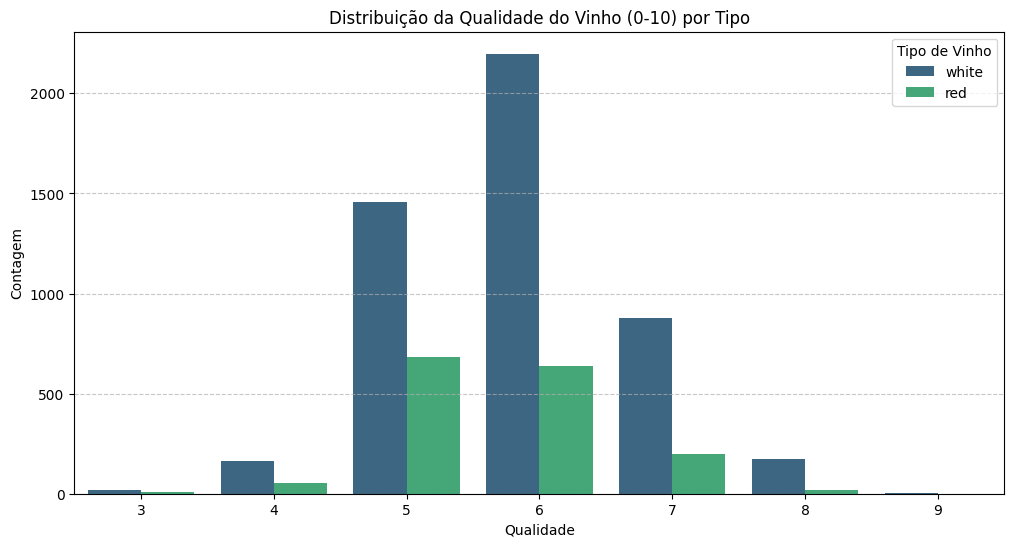


--- Contagem de cada nível de qualidade por tipo de vinho ---
type   quality
red    3            10
       4            53
       5           681
       6           638
       7           199
       8            18
white  3            20
       4           163
       5          1457
       6          2198
       7           880
       8           175
       9             5
Name: count, dtype: int64


In [3]:
# --- 2.1 Distribuição da Qualidade Original por Tipo de Vinho (EDA) ---
plt.figure(figsize=(12, 6))
sns.countplot(x='quality', data=df_wine, hue='type', palette='viridis')
plt.title('Distribuição da Qualidade do Vinho (0-10) por Tipo')
plt.xlabel('Qualidade')
plt.ylabel('Contagem')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tipo de Vinho')
plt.show()

print("\n--- Contagem de cada nível de qualidade por tipo de vinho ---")
print(df_wine.groupby('type')['quality'].value_counts().sort_index())

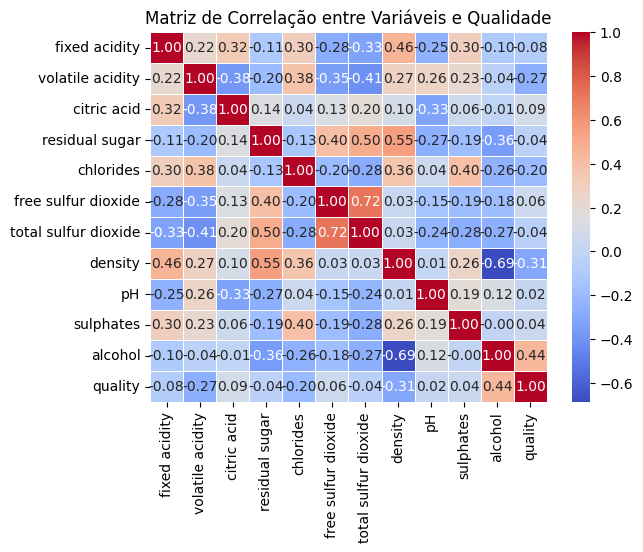


--- Correlações das variáveis físico-químicas com a Qualidade ---
quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


In [4]:
# --- 2.2 Correlações com a Qualidade (EDA) ---
correlation_matrix = df_wine.drop('type', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Variáveis e Qualidade')
plt.show()

print("\n--- Correlações das variáveis físico-químicas com a Qualidade ---")
print(correlation_matrix['quality'].sort_values(ascending=False))

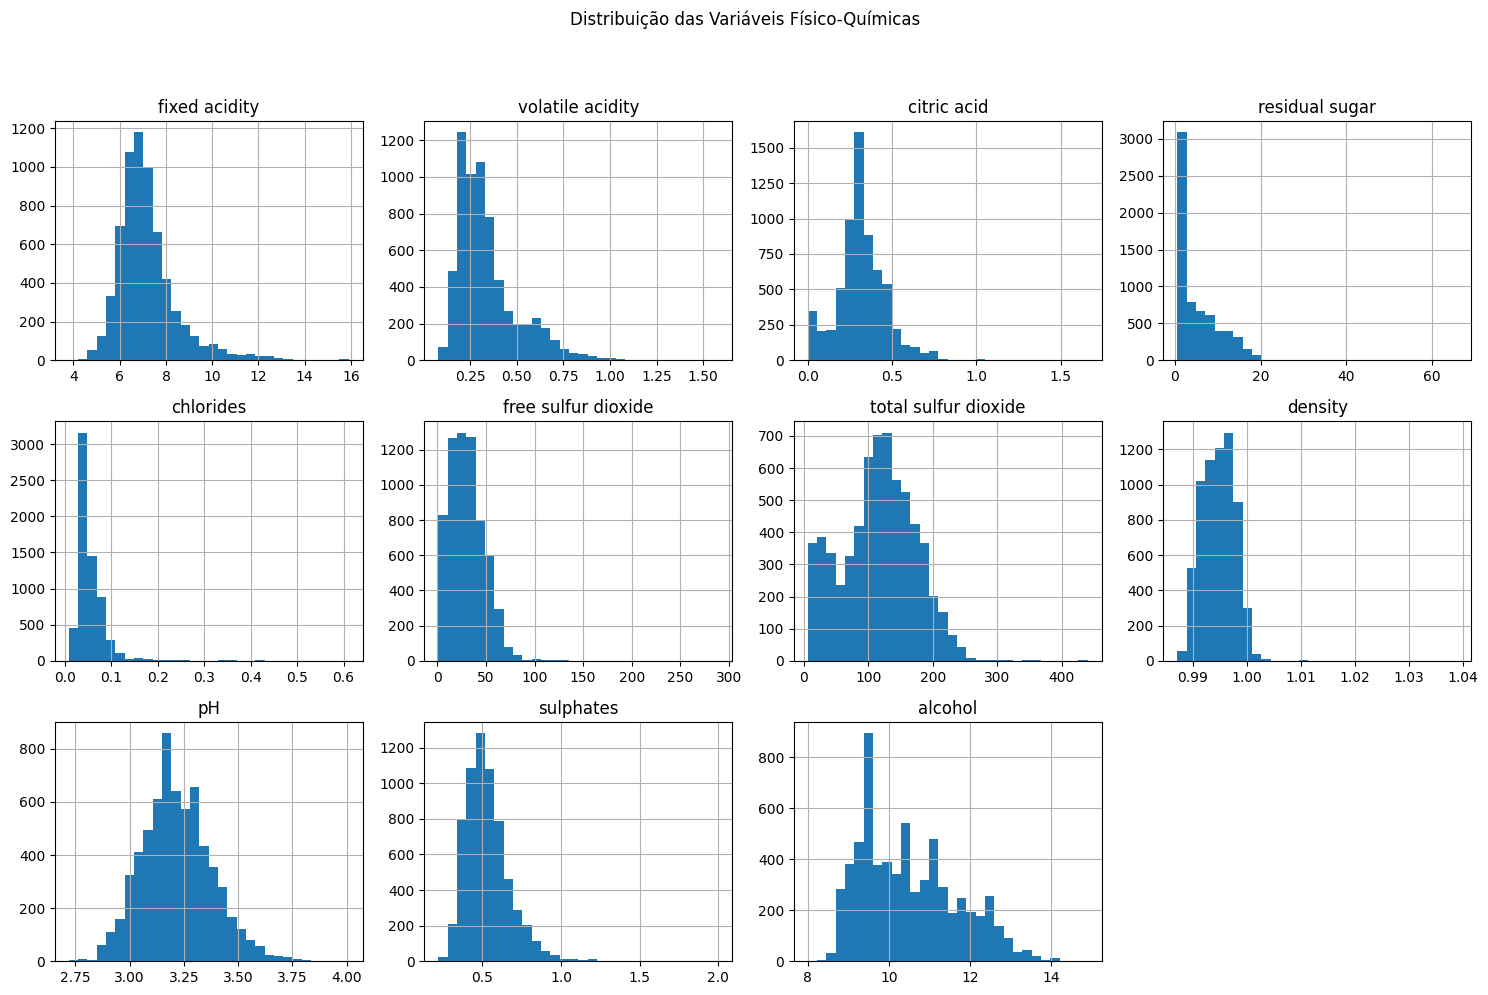

C:\Users\albet\AppData\Local\Temp\ipykernel_13112\1579420284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_13112\1579420284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_13112\1579420284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Te

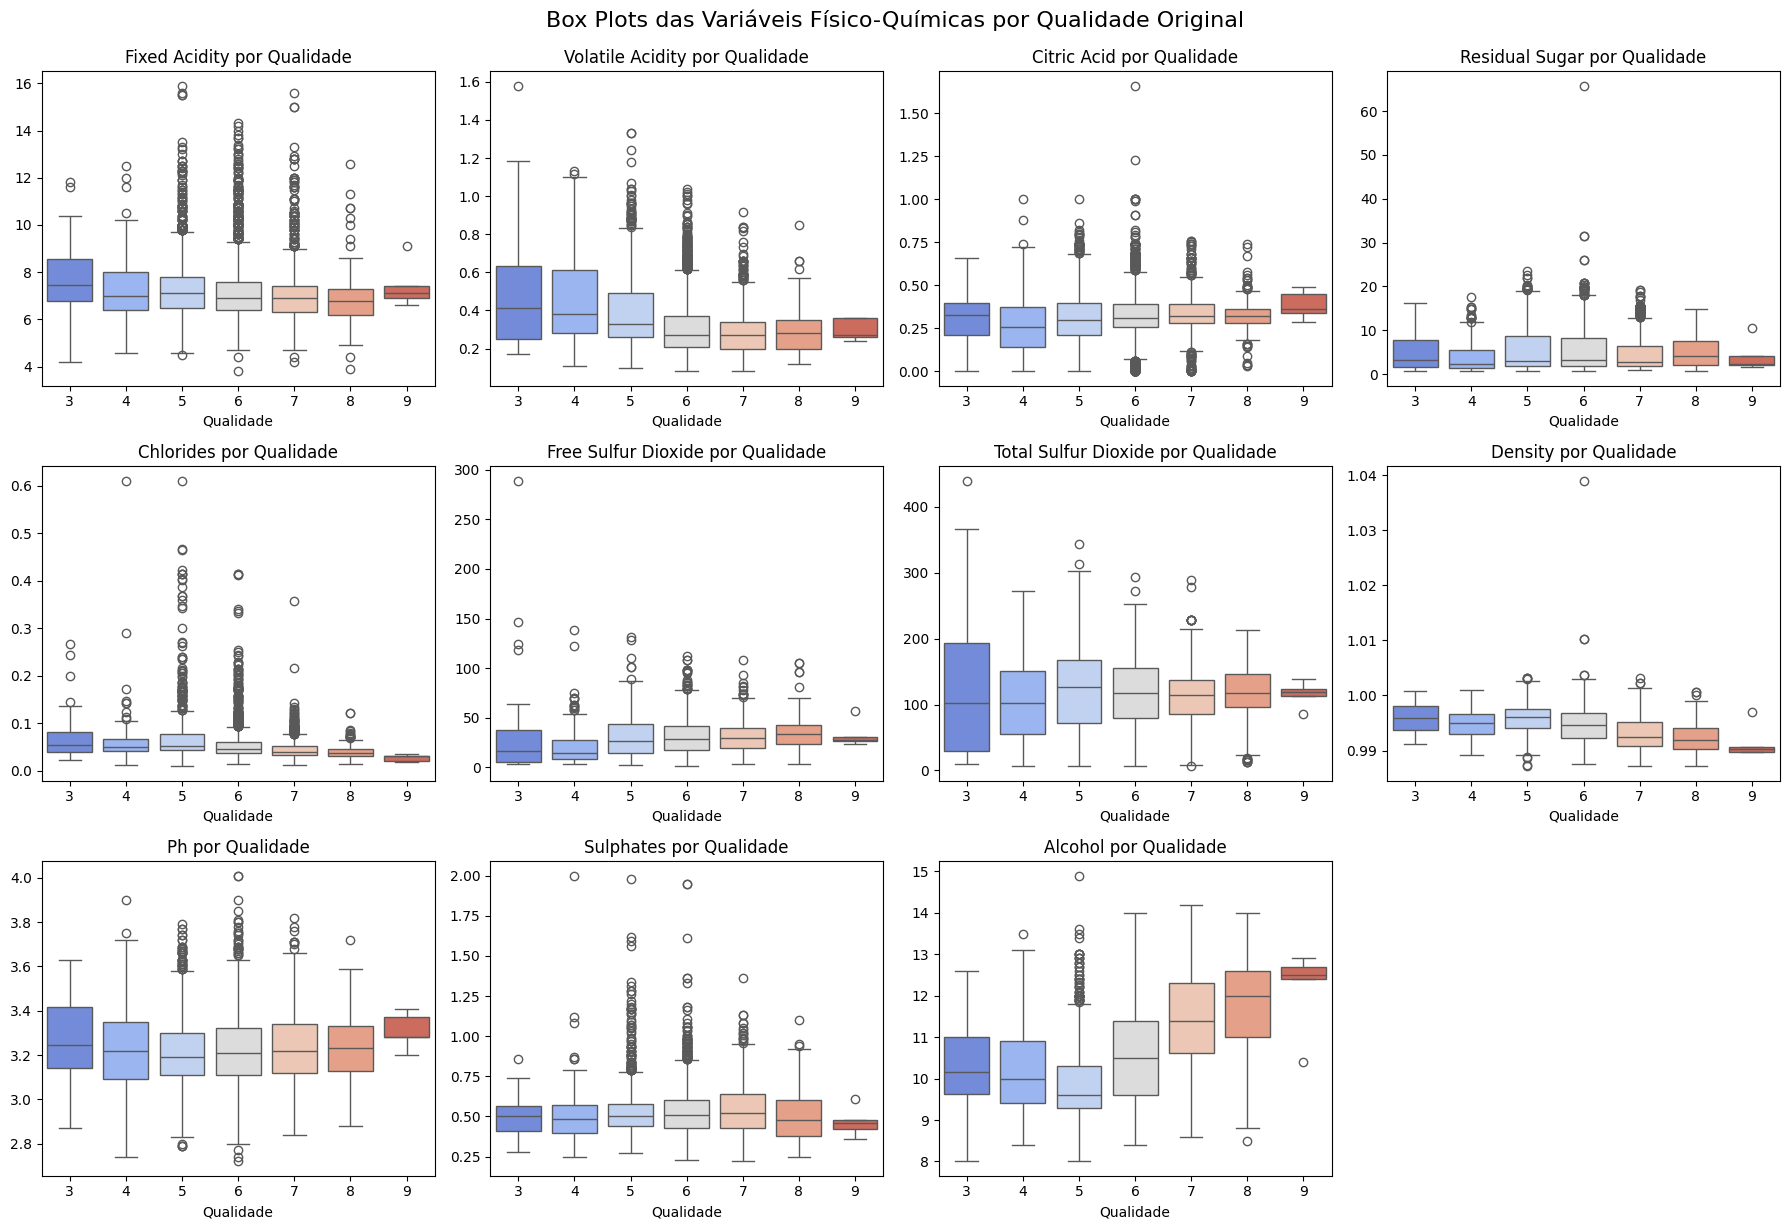

In [5]:
# --- 2.3 Distribuição das Variáveis Físico-Químicas (EDA) ---
df_wine.drop(['quality', 'type'], axis=1).hist(bins=30, figsize=(15, 10), layout=(3, 4))
plt.suptitle('Distribuição das Variáveis Físico-Químicas', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Boxplot para Outliers e Comparação por Qualidade
plt.figure(figsize=(18, 12))
features_to_plot_orig = df_wine.drop(['quality', 'type'], axis=1).columns
for i, feature in enumerate(features_to_plot_orig):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
    plt.title(f'{feature.replace("_", " ").title()} por Qualidade')
    plt.xlabel('Qualidade')
    plt.ylabel('')
plt.tight_layout()
plt.suptitle('Box Plots das Variáveis Físico-Químicas por Qualidade Original', y=1.02, fontsize=16)
plt.show()


--- Contagem da nova variável 'good_quality' (Após corte >= 6) ---
good_quality
1    4113
0    2384
Name: count, dtype: int64


C:\Users\albet\AppData\Local\Temp\ipykernel_13112\1159306096.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='good_quality', data=df_wine, palette='pastel')


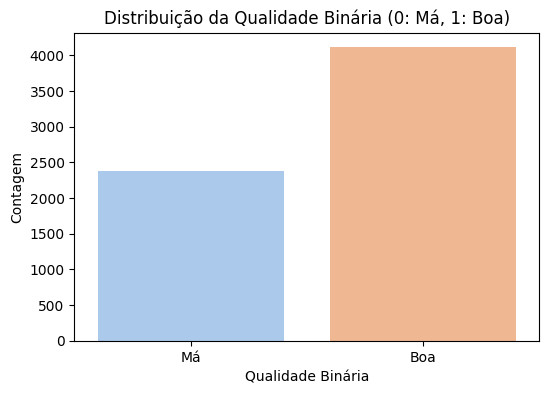

In [6]:
# --- 2.4 Criação da Variável Alvo Binária ('good_quality') ---
# Definir 'good_quality': 1 se a qualidade original for >= 6, 0 caso contrário.
df_wine['good_quality'] = df_wine['quality'].apply(lambda x: 1 if x >= 6 else 0)

print("\n--- Contagem da nova variável 'good_quality' (Após corte >= 6) ---")
print(df_wine['good_quality'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='good_quality', data=df_wine, palette='pastel')
plt.title('Distribuição da Qualidade Binária (0: Má, 1: Boa)')
plt.xlabel('Qualidade Binária')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Má', 'Boa'])
plt.show()

In [8]:
# --- 2.5 Aplicar One-Hot Encoding na coluna 'type' ---
df_processed_features = df_wine.copy()
df_processed_features = pd.get_dummies(df_processed_features, columns=['type'], drop_first=True, dtype=int)

print("\n--- Primeiras 5 linhas do DataFrame após One-Hot Encoding de 'type' ---")
print(df_processed_features.head())


--- Primeiras 5 linhas do DataFrame após One-Hot Encoding de 'type' ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  q

In [9]:
# --- 2.6 Definir Features (X) e Alvo (y) (AGORA SEM ENGENHARIA DE FEATURES AVANÇADA) ---
# X conterá apenas as 11 características físico-químicas originais + 'type_white'.
features_cols_no_engineering = df_processed_features.drop(['quality', 'good_quality'], axis=1).columns

X = df_processed_features[features_cols_no_engineering].copy()
y = df_processed_features['good_quality']

print(f"\nShape das Features (X) (SEM Engenharia de Features): {X.shape}")


Shape das Features (X) (SEM Engenharia de Features): (6497, 12)


In [10]:
# --- 2.7 Escalonamento das Features (Normalização) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Escala X (sem as features de engenharia)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\n--- Primeiras 5 linhas das Features Escalonadas (X_scaled_df) (SEM Engenharia de Features) ---")
print(X_scaled_df.head())
print("\n--- Média e Desvio Padrão das Features Escalonadas (devem ser próximos de 0 e 1) ---")
print(X_scaled_df.describe().loc[['mean', 'std']])


--- Primeiras 5 linhas das Features Escalonadas (X_scaled_df) (SEM Engenharia de Features) ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.166089         -0.423183     0.284686        3.206929  -0.314975   
1      -0.706073         -0.240949     0.147046       -0.807837  -0.200790   
2       0.682458         -0.362438     0.559966        0.306208  -0.172244   
3      -0.011808         -0.666161     0.009406        0.642523   0.056126   
4      -0.011808         -0.666161     0.009406        0.642523   0.056126   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.815565              0.959976  2.102214 -1.359049  -0.546178   
1            -0.931107              0.287618 -0.232332  0.506915  -0.277351   
2            -0.029599             -0.331660  0.134525  0.258120  -0.613385   
3             0.928254              1.243074  0.301278 -0.177272  -0.882212   
4             0.928254              1.24

In [11]:
# --- 3.1 Divisão dos Dados: Treino e Teste ---
# stratify=y é crucial para manter a proporção das classes (agora 1 majoritária, 0 minoritária)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

print("\n--- Proporção das classes em y_train (pré-SMOTE) ---")
print(y_train.value_counts(normalize=True))
print("\n--- Proporção das classes em y_test ---")
print(y_test.value_counts(normalize=True))

Shape de X_train: (5197, 12)
Shape de X_test: (1300, 12)
Shape de y_train: (5197,)
Shape de y_test: (1300,)

--- Proporção das classes em y_train (pré-SMOTE) ---
good_quality
1    0.633058
0    0.366942
Name: proportion, dtype: float64

--- Proporção das classes em y_test ---
good_quality
1    0.633077
0    0.366923
Name: proportion, dtype: float64


In [11]:
# --- 3.2 Lidando com o Desbalanceamento: SMOTE ---
smote = SMOTE(random_state=42) # Usamos SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\n--- Shape de X_train após SMOTE ---")
print(X_train_resampled.shape)
print("\n--- Contagem de classes em y_train_resampled (após SMOTE) ---")
print(y_train_resampled.value_counts())


--- Shape de X_train após SMOTE ---
(6580, 12)

--- Contagem de classes em y_train_resampled (após SMOTE) ---
good_quality
1    3290
0    3290
Name: count, dtype: int64


In [12]:
# --- 4.1 Treinamento do Modelo Random Forest (NÃO Otimizado / Baseline) ---
print("--- Treinamento do Modelo Random Forest (NÃO Otimizado / Baseline) ---")
rf_baseline_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_baseline_model.fit(X_train_resampled, y_train_resampled) # Treina nos dados balanceados

print("\nModelo Random Forest (Baseline) treinado com sucesso!")

--- Treinamento do Modelo Random Forest (NÃO Otimizado / Baseline) ---

Modelo Random Forest (Baseline) treinado com sucesso!


In [13]:
# --- 4.2 Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TREINO ---
print("\n--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TREINO ---")
y_pred_train_rf_baseline = rf_baseline_model.predict(X_train_resampled)
report_train_rf_baseline_dict = classification_report(y_train_resampled, y_pred_train_rf_baseline, output_dict=True)

data_train_rf_baseline = {
    'Modelo': ['RF Baseline (Treino)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_train_rf_baseline_dict['0']['precision'], report_train_rf_baseline_dict['0']['recall'], report_train_rf_baseline_dict['0']['f1-score'], report_train_rf_baseline_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_train_rf_baseline_dict['1']['precision'], report_train_rf_baseline_dict['1']['recall'], report_train_rf_baseline_dict['1']['f1-score'], report_train_rf_baseline_dict['1']['support'], '-'],
    'Média (Macro)': [report_train_rf_baseline_dict['macro avg']['precision'], report_train_rf_baseline_dict['macro avg']['recall'], report_train_rf_baseline_dict['macro avg']['f1-score'], '-', report_train_rf_baseline_dict['accuracy']],
    'Média Ponderada': [report_train_rf_baseline_dict['weighted avg']['precision'], report_train_rf_baseline_dict['weighted avg']['recall'], report_train_rf_baseline_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_train_rf_baseline = pd.DataFrame(data_train_rf_baseline)
df_results_train_rf_baseline.loc[df_results_train_rf_baseline['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_train_rf_baseline.to_string(index=False))
pd.reset_option('display.float_format')


--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TREINO ---
              Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Baseline (Treino) Precisão         1.000          1.000         1.000           1.000
RF Baseline (Treino)   Recall         1.000          1.000         1.000           1.000
RF Baseline (Treino) F1-Score         1.000          1.000         1.000           1.000
RF Baseline (Treino)  Suporte      3290.000       3290.000             -               -
RF Baseline (Treino) Acurácia             -              -         1.000               -


In [14]:
# --- 4.3 Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TESTE ---
print("\n--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TESTE ---")
y_pred_test_rf_baseline = rf_baseline_model.predict(X_test)
y_pred_proba_test_rf_baseline = rf_baseline_model.predict_proba(X_test)[:, 1]
report_test_rf_baseline_dict = classification_report(y_test, y_pred_test_rf_baseline, output_dict=True)

data_test_rf_baseline = {
    'Modelo': ['RF Baseline (Teste)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_test_rf_baseline_dict['0']['precision'], report_test_rf_baseline_dict['0']['recall'], report_test_rf_baseline_dict['0']['f1-score'], report_test_rf_baseline_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_test_rf_baseline_dict['1']['precision'], report_test_rf_baseline_dict['1']['recall'], report_test_rf_baseline_dict['1']['f1-score'], report_test_rf_baseline_dict['1']['support'], '-'],
    'Média (Macro)': [report_test_rf_baseline_dict['macro avg']['precision'], report_test_rf_baseline_dict['macro avg']['recall'], report_test_rf_baseline_dict['macro avg']['f1-score'], '-', report_test_rf_baseline_dict['accuracy']],
    'Média Ponderada': [report_test_rf_baseline_dict['weighted avg']['precision'], report_test_rf_baseline_dict['weighted avg']['recall'], report_test_rf_baseline_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_test_rf_baseline = pd.DataFrame(data_test_rf_baseline)
df_results_test_rf_baseline.loc[df_results_test_rf_baseline['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_test_rf_baseline.to_string(index=False))
pd.reset_option('display.float_format')


--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TESTE ---
             Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Baseline (Teste) Precisão         0.749          0.865         0.807           0.823
RF Baseline (Teste)   Recall         0.771          0.851         0.811           0.822
RF Baseline (Teste) F1-Score         0.760          0.858         0.809           0.822
RF Baseline (Teste)  Suporte       477.000        823.000             -               -
RF Baseline (Teste) Acurácia             -              -         0.822               -



--- Matriz de Confusão do Modelo RF (Baseline) (Teste) ---
[[368 109]
 [123 700]]


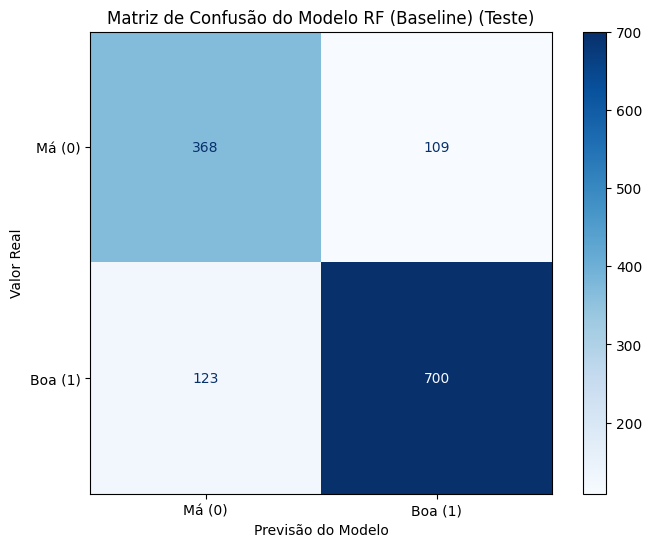

--- AUC-ROC do Modelo RF (Baseline) (Teste): 0.9041 ---


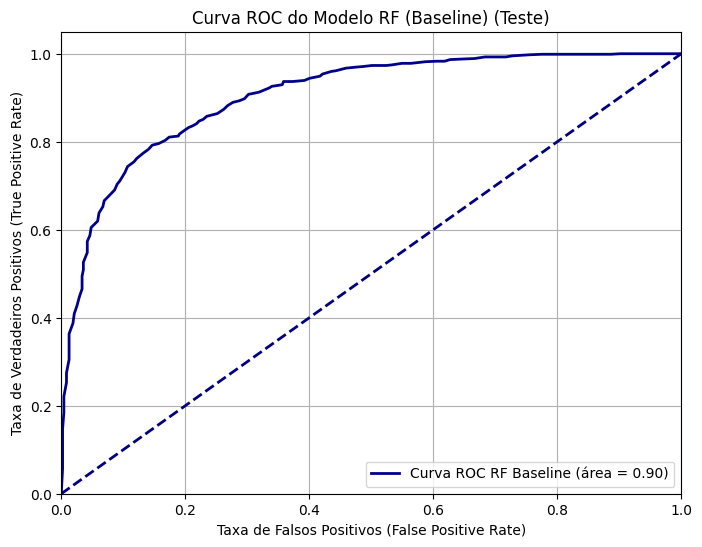

In [15]:
# --- Matriz de Confusão do Modelo RF (Baseline) (Teste) ---
cm_rf_baseline_test = confusion_matrix(y_test, y_pred_test_rf_baseline)
print("\n--- Matriz de Confusão do Modelo RF (Baseline) (Teste) ---")
print(cm_rf_baseline_test)

disp_rf_baseline_test = ConfusionMatrixDisplay(confusion_matrix=cm_rf_baseline_test, display_labels=["Má (0)", "Boa (1)"])
fig_rf_baseline_test, ax_rf_baseline_test = plt.subplots(figsize=(8, 6))
disp_rf_baseline_test.plot(cmap=plt.cm.Blues, ax=ax_rf_baseline_test)
plt.title('Matriz de Confusão do Modelo RF (Baseline) (Teste)')
plt.xlabel('Previsão do Modelo')
plt.ylabel('Valor Real')
plt.grid(False)
plt.show()

# --- AUC-ROC Score do Modelo RF (Baseline) (Teste) ---
auc_roc_rf_baseline_test = roc_auc_score(y_test, y_pred_proba_test_rf_baseline)
print(f"--- AUC-ROC do Modelo RF (Baseline) (Teste): {auc_roc_rf_baseline_test:.4f} ---")

# --- Curva ROC do Modelo RF (Baseline) (Teste) ---
fpr_rf_baseline_test, tpr_rf_baseline_test, thresholds_rf_baseline_test = roc_curve(y_test, y_pred_proba_test_rf_baseline)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_baseline_test, tpr_rf_baseline_test, color='darkblue', lw=2, label=f'Curva ROC RF Baseline (área = {auc_roc_rf_baseline_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC do Modelo RF (Baseline) (Teste)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV # Já importado, mas bom para garantir
from sklearn.ensemble import RandomForestClassifier # Já importado, mas bom para garantir

# --- 5.1 Inicializar o Modelo Random Forest (para otimização) ---
# Usamos 'rf' aqui para a instância que será otimizada pelo Grid Search
rf = RandomForestClassifier(random_state=42)

# --- 5.2 Definir o espaço de hiperparâmetros para o Grid Search do RF ---
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# --- 5.3 Configurar e Rodar o GridSearchCV para o RF ---
print("\nIniciando Grid Search para otimização de hiperparâmetros do Random Forest...")
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc', # Otimizar pela AUC-ROC
    n_jobs=-1,
    verbose=2
)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

print("\nGrid Search para Random Forest concluído!")

# --- 5.4 Exibir os Melhores Parâmetros e Pontuação do RF Otimizado ---
print("\n--- Melhores hiperparâmetros do Random Forest encontrados ---")
print(grid_search_rf.best_params_)
print(f"Melhor pontuação AUC-ROC do RF na validação cruzada: {grid_search_rf.best_score_:.4f}")

# --- 5.5 Obter o Melhor Modelo RF Otimizado ---
best_rf_model = grid_search_rf.best_estimator_


Iniciando Grid Search para otimização de hiperparâmetros do Random Forest...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Grid Search para Random Forest concluído!

--- Melhores hiperparâmetros do Random Forest encontrados ---
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhor pontuação AUC-ROC do RF na validação cruzada: 0.9372


In [17]:
# Certifique-se de que 'best_rf_model', 'X_train_resampled', 'y_train_resampled',
# 'X_test', 'y_test' estão disponíveis de execuções anteriores (Passos 1-5).
# Se você executou o notebook completo até agora, eles devem estar no ambiente.

# --- 6.1 Avaliar o Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---
print("\n--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---")
y_pred_train_rf_optimized = best_rf_model.predict(X_train_resampled)
report_train_rf_optimized_dict = classification_report(y_train_resampled, y_pred_train_rf_optimized, output_dict=True)

data_train_rf_optimized = {
    'Modelo': ['RF Otimizado (Treino)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_train_rf_optimized_dict['0']['precision'], report_train_rf_optimized_dict['0']['recall'], report_train_rf_optimized_dict['0']['f1-score'], report_train_rf_optimized_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_train_rf_optimized_dict['1']['precision'], report_train_rf_optimized_dict['1']['recall'], report_train_rf_optimized_dict['1']['f1-score'], report_train_rf_optimized_dict['1']['support'], '-'],
    'Média (Macro)': [report_train_rf_optimized_dict['macro avg']['precision'], report_train_rf_optimized_dict['macro avg']['recall'], report_train_rf_optimized_dict['macro avg']['f1-score'], '-', report_train_rf_optimized_dict['accuracy']],
    'Média Ponderada': [report_train_rf_optimized_dict['weighted avg']['precision'], report_train_rf_optimized_dict['weighted avg']['recall'], report_train_rf_optimized_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_train_rf_optimized = pd.DataFrame(data_train_rf_optimized)
df_results_train_rf_optimized.loc[df_results_train_rf_optimized['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_train_rf_optimized.to_string(index=False))
pd.reset_option('display.float_format')


# --- 6.2 Avaliar o Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---
print("\n--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---")
y_pred_test_rf_optimized = best_rf_model.predict(X_test)
y_pred_proba_test_rf_optimized = best_rf_model.predict_proba(X_test)[:, 1]
report_test_rf_optimized_dict = classification_report(y_test, y_pred_test_rf_optimized, output_dict=True)

data_test_rf_optimized = {
    'Modelo': ['RF Otimizado (Teste)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_test_rf_optimized_dict['0']['precision'], report_test_rf_optimized_dict['0']['recall'], report_test_rf_optimized_dict['0']['f1-score'], report_test_rf_optimized_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_test_rf_optimized_dict['1']['precision'], report_test_rf_optimized_dict['1']['recall'], report_test_rf_optimized_dict['1']['f1-score'], report_test_rf_optimized_dict['1']['support'], '-'],
    'Média (Macro)': [report_test_rf_optimized_dict['macro avg']['precision'], report_test_rf_optimized_dict['macro avg']['recall'], report_test_rf_optimized_dict['macro avg']['f1-score'], '-', report_test_rf_optimized_dict['accuracy']],
    'Média Ponderada': [report_test_rf_optimized_dict['weighted avg']['precision'], report_test_rf_optimized_dict['weighted avg']['recall'], report_test_rf_optimized_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_test_rf_optimized = pd.DataFrame(data_test_rf_optimized)
df_results_test_rf_optimized.loc[df_results_test_rf_optimized['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_test_rf_optimized.to_string(index=False))
pd.reset_option('display.float_format')


--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---


               Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Otimizado (Treino) Precisão         0.984          1.000         0.992           0.992
RF Otimizado (Treino)   Recall         1.000          0.984         0.992           0.992
RF Otimizado (Treino) F1-Score         0.992          0.992         0.992           0.992
RF Otimizado (Treino)  Suporte      3290.000       3290.000             -               -
RF Otimizado (Treino) Acurácia             -              -         0.992               -

--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---
              Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Otimizado (Teste) Precisão         0.740          0.868         0.804           0.821
RF Otimizado (Teste)   Recall         0.780          0.841         0.810           0.818
RF Otimizado (Teste) F1-Score         0.759          0.854         0.807           0.819
RF Otimizado (Teste)  Suporte 


--- Matriz de Confusão do Modelo RF Otimizado (Teste) ---
[[372 105]
 [131 692]]


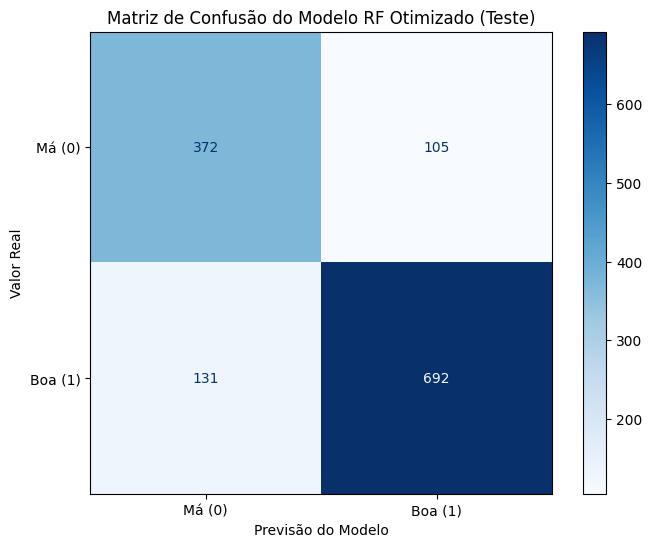

--- AUC-ROC do Modelo RF Otimizado (Teste): 0.9010 ---


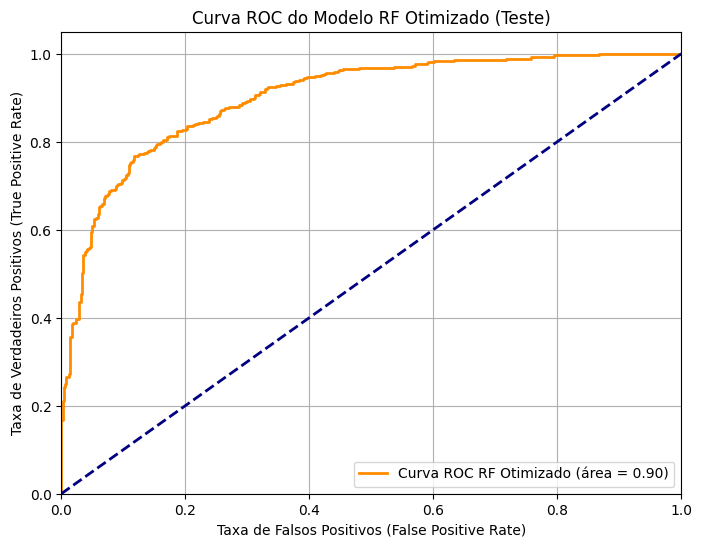


--- Importância das Variáveis no Modelo RF Otimizado ---
                 Feature  Importance
10               alcohol    0.190283
1       volatile acidity    0.117216
7                density    0.101845
5    free sulfur dioxide    0.081488
4              chlorides    0.079085
2            citric acid    0.076324
9              sulphates    0.076290
6   total sulfur dioxide    0.075265
3         residual sugar    0.069202
8                     pH    0.065966
0          fixed acidity    0.063077
11            type_white    0.003959


C:\Users\albet\AppData\Local\Temp\ipykernel_25152\629992831.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df_rf_optimized, palette='magma')


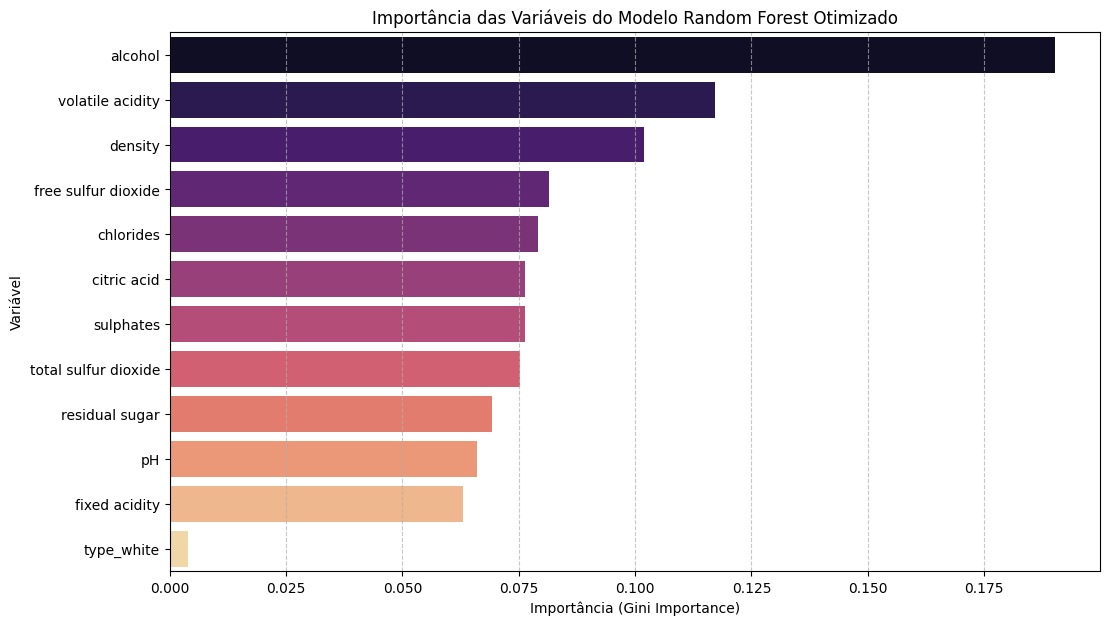


--- As 5 Features Mais Relevantes para o Modelo RF Otimizado: ['alcohol', 'volatile acidity', 'density', 'free sulfur dioxide', 'chlorides'] ---


C:\Users\albet\AppData\Local\Temp\ipykernel_25152\629992831.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_25152\629992831.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_25152\629992831.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
C:\Users\albet\AppD

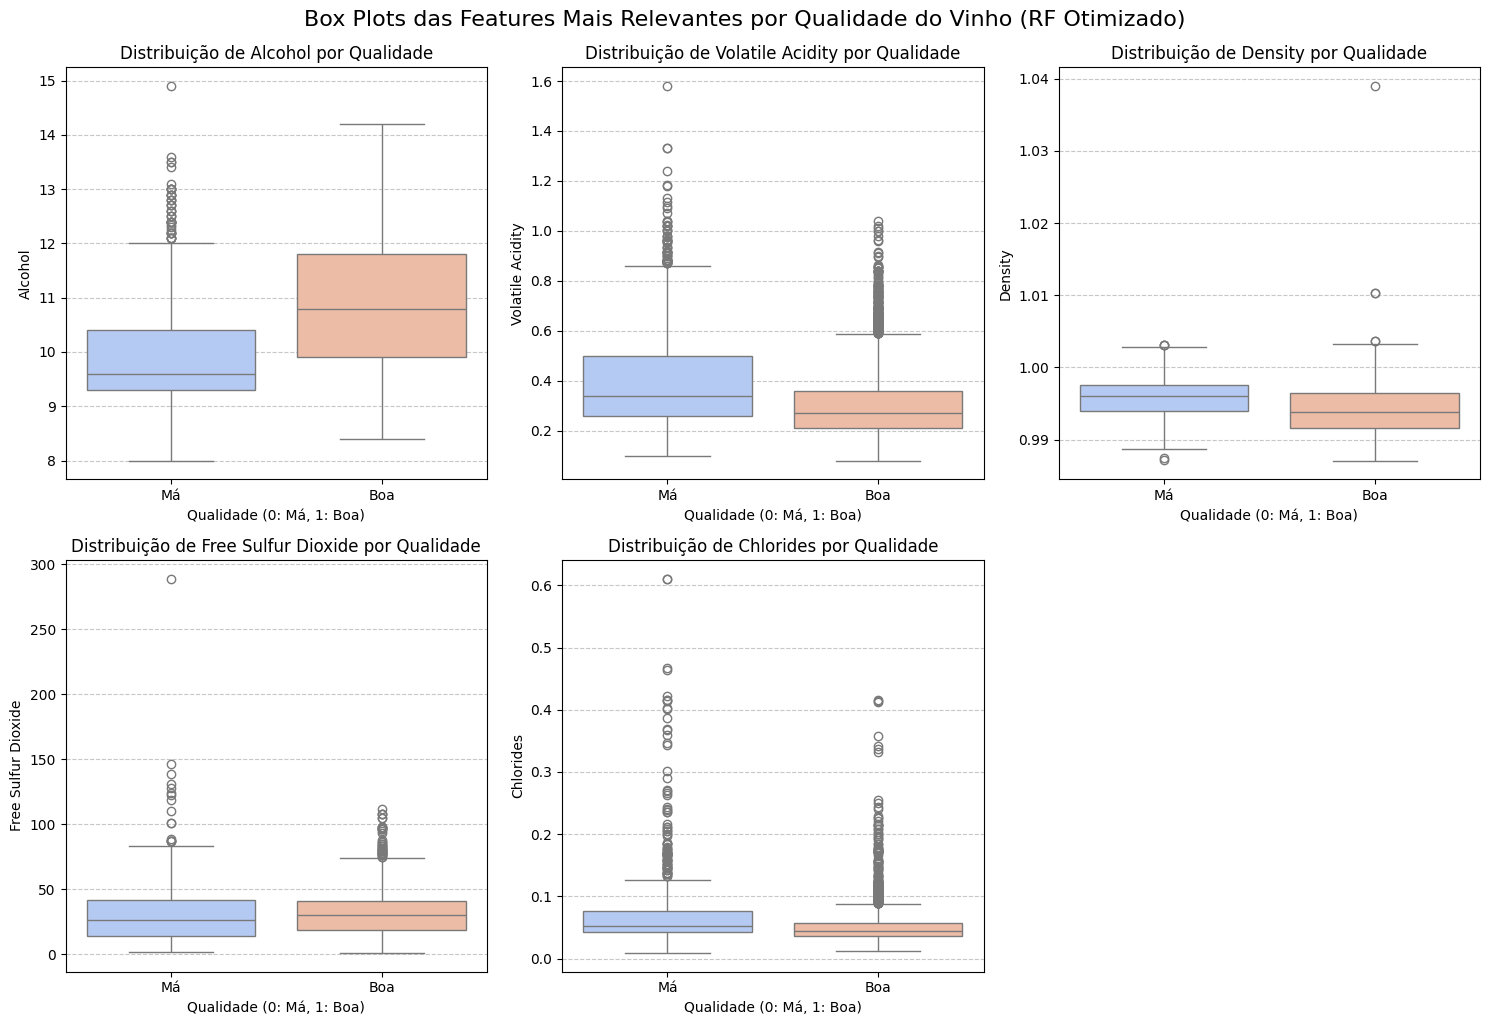

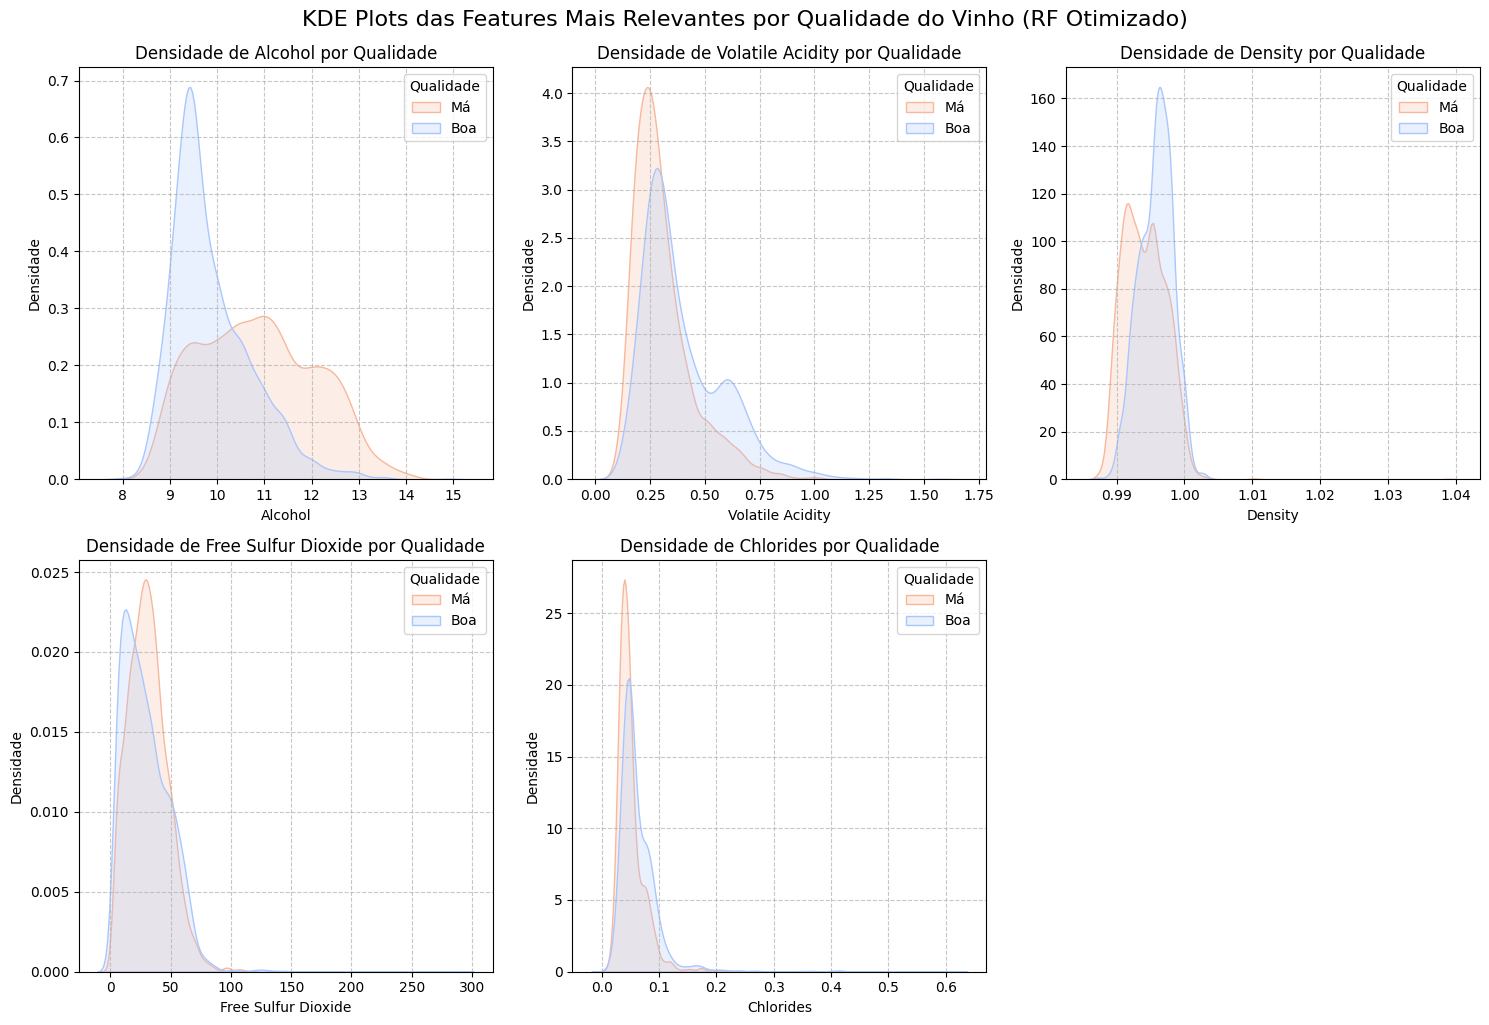

In [18]:
# --- Matriz de Confusão do Modelo RF Otimizado (Teste) ---
cm_rf_optimized_test = confusion_matrix(y_test, y_pred_test_rf_optimized)
print("\n--- Matriz de Confusão do Modelo RF Otimizado (Teste) ---")
print(cm_rf_optimized_test)

disp_rf_optimized_test = ConfusionMatrixDisplay(confusion_matrix=cm_rf_optimized_test, display_labels=["Má (0)", "Boa (1)"])
fig_rf_optimized_test, ax_rf_optimized_test = plt.subplots(figsize=(8, 6))
disp_rf_optimized_test.plot(cmap=plt.cm.Blues, ax=ax_rf_optimized_test)
plt.title('Matriz de Confusão do Modelo RF Otimizado (Teste)')
plt.xlabel('Previsão do Modelo')
plt.ylabel('Valor Real')
plt.grid(False)
plt.show()

# --- AUC-ROC Score do Modelo RF Otimizado (Teste) ---
auc_roc_rf_optimized_test = roc_auc_score(y_test, y_pred_proba_test_rf_optimized)
print(f"--- AUC-ROC do Modelo RF Otimizado (Teste): {auc_roc_rf_optimized_test:.4f} ---")

# --- Curva ROC do Modelo RF Otimizado (Teste) ---
fpr_rf_optimized_test, tpr_rf_optimized_test, thresholds_rf_optimized_test = roc_curve(y_test, y_pred_proba_test_rf_optimized)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_optimized_test, tpr_rf_optimized_test, color='darkorange', lw=2, label=f'Curva ROC RF Otimizado (área = {auc_roc_rf_optimized_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC do Modelo RF Otimizado (Teste)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 6.3 Identificação da Importância das Variáveis do Modelo RF Otimizado ---
feature_importances_rf_optimized = best_rf_model.feature_importances_
features_df_rf_optimized = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rf_optimized})
features_df_rf_optimized = features_df_rf_optimized.sort_values(by='Importance', ascending=False)

print("\n--- Importância das Variáveis no Modelo RF Otimizado ---")
print(features_df_rf_optimized)

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df_rf_optimized, palette='magma')
plt.title('Importância das Variáveis do Modelo Random Forest Otimizado')
plt.xlabel('Importância (Gini Importance)')
plt.ylabel('Variável')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# --- 6.4 Visualização das Features Mais Relevantes (Boxplots e KDE) ---
top_n_features_rf_optimized = features_df_rf_optimized['Feature'].head(5).tolist()

print(f"\n--- As 5 Features Mais Relevantes para o Modelo RF Otimizado: {top_n_features_rf_optimized} ---")

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_n_features_rf_optimized):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='good_quality', y=feature, data=df_wine, palette='coolwarm')
    plt.title(f'Distribuição de {feature.replace("_", " ").title()} por Qualidade')
    plt.xlabel('Qualidade (0: Má, 1: Boa)')
    plt.ylabel(feature.replace("_", " ").title())
    plt.xticks(ticks=[0, 1], labels=['Má', 'Boa'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle('Box Plots das Features Mais Relevantes por Qualidade do Vinho (RF Otimizado)', y=1.02, fontsize=16)
plt.show()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_n_features_rf_optimized):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=df_wine, x=feature, hue='good_quality', fill=True, common_norm=False, palette='coolwarm')
    plt.title(f'Densidade de {feature.replace("_", " ").title()} por Qualidade')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Densidade')
    plt.legend(title='Qualidade', labels=['Má', 'Boa'])
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle('KDE Plots das Features Mais Relevantes por Qualidade do Vinho (RF Otimizado)', y=1.02, fontsize=16)
plt.show()

In [12]:
# --- 3.2 Lidando com o Desbalanceamento: SMOTEENN ---
from imblearn.combine import SMOTEENN # Importa a técnica SMOTEENN

# Inicializa o SMOTEENN.
# random_state para reprodutibilidade.
smoteenn = SMOTEENN(random_state=42)

# Aplica o SMOTEENN no conjunto de TREINO.
# NOTA: O SMOTEENN pode não resultar em um balanceamento 1:1 exato
# e pode reduzir o número total de amostras de treino devido à limpeza.
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

print("\n--- Shape de X_train após SMOTEENN ---")
print(X_train_resampled.shape)
print("\n--- Contagem de classes em y_train_resampled (após SMOTEENN) ---")
print(y_train_resampled.value_counts())


--- Shape de X_train após SMOTEENN ---
(4147, 12)

--- Contagem de classes em y_train_resampled (após SMOTEENN) ---
good_quality
0    2259
1    1888
Name: count, dtype: int64


In [13]:
print("--- Treinamento do Modelo Random Forest (NÃO Otimizado / Baseline) ---")
rf_baseline_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_baseline_model.fit(X_train_resampled, y_train_resampled) # Treina nos dados balanceados

print("\nModelo Random Forest (Baseline) treinado com sucesso!")

--- Treinamento do Modelo Random Forest (NÃO Otimizado / Baseline) ---

Modelo Random Forest (Baseline) treinado com sucesso!


In [14]:
# --- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TREINO COM SMOTEEN ---
print("\n--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TREINO ---")
y_pred_train_rf_baseline = rf_baseline_model.predict(X_train_resampled)
report_train_rf_baseline_dict = classification_report(y_train_resampled, y_pred_train_rf_baseline, output_dict=True)

data_train_rf_baseline = {
    'Modelo': ['RF Baseline (Treino)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_train_rf_baseline_dict['0']['precision'], report_train_rf_baseline_dict['0']['recall'], report_train_rf_baseline_dict['0']['f1-score'], report_train_rf_baseline_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_train_rf_baseline_dict['1']['precision'], report_train_rf_baseline_dict['1']['recall'], report_train_rf_baseline_dict['1']['f1-score'], report_train_rf_baseline_dict['1']['support'], '-'],
    'Média (Macro)': [report_train_rf_baseline_dict['macro avg']['precision'], report_train_rf_baseline_dict['macro avg']['recall'], report_train_rf_baseline_dict['macro avg']['f1-score'], '-', report_train_rf_baseline_dict['accuracy']],
    'Média Ponderada': [report_train_rf_baseline_dict['weighted avg']['precision'], report_train_rf_baseline_dict['weighted avg']['recall'], report_train_rf_baseline_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_train_rf_baseline = pd.DataFrame(data_train_rf_baseline)
df_results_train_rf_baseline.loc[df_results_train_rf_baseline['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_train_rf_baseline.to_string(index=False))
pd.reset_option('display.float_format')


--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TREINO ---
              Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Baseline (Treino) Precisão         1.000          1.000         1.000           1.000
RF Baseline (Treino)   Recall         1.000          1.000         1.000           1.000
RF Baseline (Treino) F1-Score         1.000          1.000         1.000           1.000
RF Baseline (Treino)  Suporte      2259.000       1888.000             -               -
RF Baseline (Treino) Acurácia             -              -         1.000               -


In [15]:
# --- 4.3 Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TESTE ---
print("\n--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TESTE ---")
y_pred_test_rf_baseline = rf_baseline_model.predict(X_test)
y_pred_proba_test_rf_baseline = rf_baseline_model.predict_proba(X_test)[:, 1]
report_test_rf_baseline_dict = classification_report(y_test, y_pred_test_rf_baseline, output_dict=True)

data_test_rf_baseline = {
    'Modelo': ['RF Baseline (Teste)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_test_rf_baseline_dict['0']['precision'], report_test_rf_baseline_dict['0']['recall'], report_test_rf_baseline_dict['0']['f1-score'], report_test_rf_baseline_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_test_rf_baseline_dict['1']['precision'], report_test_rf_baseline_dict['1']['recall'], report_test_rf_baseline_dict['1']['f1-score'], report_test_rf_baseline_dict['1']['support'], '-'],
    'Média (Macro)': [report_test_rf_baseline_dict['macro avg']['precision'], report_test_rf_baseline_dict['macro avg']['recall'], report_test_rf_baseline_dict['macro avg']['f1-score'], '-', report_test_rf_baseline_dict['accuracy']],
    'Média Ponderada': [report_test_rf_baseline_dict['weighted avg']['precision'], report_test_rf_baseline_dict['weighted avg']['recall'], report_test_rf_baseline_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_test_rf_baseline = pd.DataFrame(data_test_rf_baseline)
df_results_test_rf_baseline.loc[df_results_test_rf_baseline['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_test_rf_baseline.to_string(index=False))
pd.reset_option('display.float_format')


--- Avaliação do Modelo Random Forest (Baseline) no CONJUNTO DE TESTE ---
             Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Baseline (Teste) Precisão         0.660          0.859         0.760           0.786
RF Baseline (Teste)   Recall         0.784          0.765         0.775           0.772
RF Baseline (Teste) F1-Score         0.716          0.810         0.763           0.776
RF Baseline (Teste)  Suporte       477.000        823.000             -               -
RF Baseline (Teste) Acurácia             -              -         0.772               -


In [16]:
from sklearn.model_selection import GridSearchCV # Já importado, mas bom para garantir
from sklearn.ensemble import RandomForestClassifier # Já importado, mas bom para garantir

# --- 5.1 Inicializar o Modelo Random Forest (para otimização) ---
# Usamos 'rf' aqui para a instância que será otimizada pelo Grid Search
rf = RandomForestClassifier(random_state=42)

# --- 5.2 Definir o espaço de hiperparâmetros para o Grid Search do RF ---
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# --- 5.3 Configurar e Rodar o GridSearchCV para o RF ---
print("\nIniciando Grid Search para otimização de hiperparâmetros do Random Forest...")
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc', # Otimizar pela AUC-ROC
    n_jobs=-1,
    verbose=2
)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

print("\nGrid Search para Random Forest concluído!")

# --- 5.4 Exibir os Melhores Parâmetros e Pontuação do RF Otimizado ---
print("\n--- Melhores hiperparâmetros do Random Forest encontrados ---")
print(grid_search_rf.best_params_)
print(f"Melhor pontuação AUC-ROC do RF na validação cruzada: {grid_search_rf.best_score_:.4f}")

# --- 5.5 Obter o Melhor Modelo RF Otimizado ---
best_rf_model = grid_search_rf.best_estimator_


Iniciando Grid Search para otimização de hiperparâmetros do Random Forest...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Grid Search para Random Forest concluído!

--- Melhores hiperparâmetros do Random Forest encontrados ---
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhor pontuação AUC-ROC do RF na validação cruzada: 0.9932


In [17]:
# Certifique-se de que 'best_rf_model', 'X_train_resampled', 'y_train_resampled',
# 'X_test', 'y_test' estão disponíveis de execuções anteriores (Passos 1-5).
# Se você executou o notebook completo até agora, eles devem estar no ambiente.

# --- 6.1 Avaliar o Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---
print("\n--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---")
y_pred_train_rf_optimized = best_rf_model.predict(X_train_resampled)
report_train_rf_optimized_dict = classification_report(y_train_resampled, y_pred_train_rf_optimized, output_dict=True)

data_train_rf_optimized = {
    'Modelo': ['RF Otimizado (Treino)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_train_rf_optimized_dict['0']['precision'], report_train_rf_optimized_dict['0']['recall'], report_train_rf_optimized_dict['0']['f1-score'], report_train_rf_optimized_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_train_rf_optimized_dict['1']['precision'], report_train_rf_optimized_dict['1']['recall'], report_train_rf_optimized_dict['1']['f1-score'], report_train_rf_optimized_dict['1']['support'], '-'],
    'Média (Macro)': [report_train_rf_optimized_dict['macro avg']['precision'], report_train_rf_optimized_dict['macro avg']['recall'], report_train_rf_optimized_dict['macro avg']['f1-score'], '-', report_train_rf_optimized_dict['accuracy']],
    'Média Ponderada': [report_train_rf_optimized_dict['weighted avg']['precision'], report_train_rf_optimized_dict['weighted avg']['recall'], report_train_rf_optimized_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_train_rf_optimized = pd.DataFrame(data_train_rf_optimized)
df_results_train_rf_optimized.loc[df_results_train_rf_optimized['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_train_rf_optimized.to_string(index=False))
pd.reset_option('display.float_format')


# --- 6.2 Avaliar o Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---
print("\n--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---")
y_pred_test_rf_optimized = best_rf_model.predict(X_test)
y_pred_proba_test_rf_optimized = best_rf_model.predict_proba(X_test)[:, 1]
report_test_rf_optimized_dict = classification_report(y_test, y_pred_test_rf_optimized, output_dict=True)

data_test_rf_optimized = {
    'Modelo': ['RF Otimizado (Teste)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_test_rf_optimized_dict['0']['precision'], report_test_rf_optimized_dict['0']['recall'], report_test_rf_optimized_dict['0']['f1-score'], report_test_rf_optimized_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_test_rf_optimized_dict['1']['precision'], report_test_rf_optimized_dict['1']['recall'], report_test_rf_optimized_dict['1']['f1-score'], report_test_rf_optimized_dict['1']['support'], '-'],
    'Média (Macro)': [report_test_rf_optimized_dict['macro avg']['precision'], report_test_rf_optimized_dict['macro avg']['recall'], report_test_rf_optimized_dict['macro avg']['f1-score'], '-', report_test_rf_optimized_dict['accuracy']],
    'Média Ponderada': [report_test_rf_optimized_dict['weighted avg']['precision'], report_test_rf_optimized_dict['weighted avg']['recall'], report_test_rf_optimized_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_test_rf_optimized = pd.DataFrame(data_test_rf_optimized)
df_results_test_rf_optimized.loc[df_results_test_rf_optimized['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_test_rf_optimized.to_string(index=False))
pd.reset_option('display.float_format')


--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---
               Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Otimizado (Treino) Precisão         1.000          1.000         1.000           1.000
RF Otimizado (Treino)   Recall         1.000          1.000         1.000           1.000
RF Otimizado (Treino) F1-Score         1.000          1.000         1.000           1.000
RF Otimizado (Treino)  Suporte      2259.000       1888.000             -               -
RF Otimizado (Treino) Acurácia             -              -         1.000               -

--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---
              Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Otimizado (Teste) Precisão         0.653          0.858         0.756           0.783
RF Otimizado (Teste)   Recall         0.784          0.758         0.771           0.768
RF Otimizado (Teste) F1-Score         0.712 

In [18]:
# --- 3.3 Lidando com o Desbalanceamento: ADASYN ---
from imblearn.over_sampling import ADASYN # Importa a técnica ADASYN

# Inicializa o ADASYN.
# random_state para reprodutibilidade.
adasyn = ADASYN(random_state=42)

# Aplica o ADASYN no conjunto de TREINO.
# O ADASYN gera amostras sintéticas de forma adaptativa.
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print("\n--- Shape de X_train após ADASYN ---")
print(X_train_resampled.shape)
print("\n--- Contagem de classes em y_train_resampled (após ADASYN) ---")
print(y_train_resampled.value_counts())


--- Shape de X_train após ADASYN ---
(6478, 12)

--- Contagem de classes em y_train_resampled (após ADASYN) ---
good_quality
1    3290
0    3188
Name: count, dtype: int64


In [19]:
from sklearn.model_selection import GridSearchCV # Já importado, mas bom para garantir
from sklearn.ensemble import RandomForestClassifier # Já importado, mas bom para garantir

# --- 5.1 Inicializar o Modelo Random Forest (para otimização) ---
# Usamos 'rf' aqui para a instância que será otimizada pelo Grid Search
rf = RandomForestClassifier(random_state=42)

# --- 5.2 Definir o espaço de hiperparâmetros para o Grid Search do RF ---
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# --- 5.3 Configurar e Rodar o GridSearchCV para o RF ---
print("\nIniciando Grid Search para otimização de hiperparâmetros do Random Forest...")
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc', # Otimizar pela AUC-ROC
    n_jobs=-1,
    verbose=2
)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

print("\nGrid Search para Random Forest concluído!")

# --- 5.4 Exibir os Melhores Parâmetros e Pontuação do RF Otimizado ---
print("\n--- Melhores hiperparâmetros do Random Forest encontrados ---")
print(grid_search_rf.best_params_)
print(f"Melhor pontuação AUC-ROC do RF na validação cruzada: {grid_search_rf.best_score_:.4f}")

# --- 5.5 Obter o Melhor Modelo RF Otimizado ---
best_rf_model = grid_search_rf.best_estimator_


Iniciando Grid Search para otimização de hiperparâmetros do Random Forest...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Grid Search para Random Forest concluído!

--- Melhores hiperparâmetros do Random Forest encontrados ---
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhor pontuação AUC-ROC do RF na validação cruzada: 0.9264


In [20]:
# Certifique-se de que 'best_rf_model', 'X_train_resampled', 'y_train_resampled',
# 'X_test', 'y_test' estão disponíveis de execuções anteriores (Passos 1-5).
# Se você executou o notebook completo até agora, eles devem estar no ambiente.

# --- 6.1 Avaliar o Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---
print("\n--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---")
y_pred_train_rf_optimized = best_rf_model.predict(X_train_resampled)
report_train_rf_optimized_dict = classification_report(y_train_resampled, y_pred_train_rf_optimized, output_dict=True)

data_train_rf_optimized = {
    'Modelo': ['RF Otimizado (Treino)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_train_rf_optimized_dict['0']['precision'], report_train_rf_optimized_dict['0']['recall'], report_train_rf_optimized_dict['0']['f1-score'], report_train_rf_optimized_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_train_rf_optimized_dict['1']['precision'], report_train_rf_optimized_dict['1']['recall'], report_train_rf_optimized_dict['1']['f1-score'], report_train_rf_optimized_dict['1']['support'], '-'],
    'Média (Macro)': [report_train_rf_optimized_dict['macro avg']['precision'], report_train_rf_optimized_dict['macro avg']['recall'], report_train_rf_optimized_dict['macro avg']['f1-score'], '-', report_train_rf_optimized_dict['accuracy']],
    'Média Ponderada': [report_train_rf_optimized_dict['weighted avg']['precision'], report_train_rf_optimized_dict['weighted avg']['recall'], report_train_rf_optimized_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_train_rf_optimized = pd.DataFrame(data_train_rf_optimized)
df_results_train_rf_optimized.loc[df_results_train_rf_optimized['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_train_rf_optimized.to_string(index=False))
pd.reset_option('display.float_format')


# --- 6.2 Avaliar o Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---
print("\n--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---")
y_pred_test_rf_optimized = best_rf_model.predict(X_test)
y_pred_proba_test_rf_optimized = best_rf_model.predict_proba(X_test)[:, 1]
report_test_rf_optimized_dict = classification_report(y_test, y_pred_test_rf_optimized, output_dict=True)

data_test_rf_optimized = {
    'Modelo': ['RF Otimizado (Teste)'] * 5,
    'Métrica': ['Precisão', 'Recall', 'F1-Score', 'Suporte', 'Acurácia'],
    'Classe 0 (Má)': [report_test_rf_optimized_dict['0']['precision'], report_test_rf_optimized_dict['0']['recall'], report_test_rf_optimized_dict['0']['f1-score'], report_test_rf_optimized_dict['0']['support'], '-'],
    'Classe 1 (Boa)': [report_test_rf_optimized_dict['1']['precision'], report_test_rf_optimized_dict['1']['recall'], report_test_rf_optimized_dict['1']['f1-score'], report_test_rf_optimized_dict['1']['support'], '-'],
    'Média (Macro)': [report_test_rf_optimized_dict['macro avg']['precision'], report_test_rf_optimized_dict['macro avg']['recall'], report_test_rf_optimized_dict['macro avg']['f1-score'], '-', report_test_rf_optimized_dict['accuracy']],
    'Média Ponderada': [report_test_rf_optimized_dict['weighted avg']['precision'], report_test_rf_optimized_dict['weighted avg']['recall'], report_test_rf_optimized_dict['weighted avg']['f1-score'], '-', '-']
}
df_results_test_rf_optimized = pd.DataFrame(data_test_rf_optimized)
df_results_test_rf_optimized.loc[df_results_test_rf_optimized['Métrica'] == 'Acurácia', ['Classe 0 (Má)', 'Classe 1 (Boa)', 'Média Ponderada']] = '-'

pd.set_option('display.float_format', lambda x: '%.3f' % x if isinstance(x, (float, int)) else x)
print(df_results_test_rf_optimized.to_string(index=False))
pd.reset_option('display.float_format')


--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TREINO ---
               Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Otimizado (Treino) Precisão         0.983          1.000         0.992           0.992
RF Otimizado (Treino)   Recall         1.000          0.984         0.992           0.992
RF Otimizado (Treino) F1-Score         0.992          0.992         0.992           0.992
RF Otimizado (Treino)  Suporte      3188.000       3290.000             -               -
RF Otimizado (Treino) Acurácia             -              -         0.992               -

--- Avaliação do Modelo Random Forest Otimizado no CONJUNTO DE TESTE ---
              Modelo  Métrica Classe 0 (Má) Classe 1 (Boa) Média (Macro) Média Ponderada
RF Otimizado (Teste) Precisão         0.728          0.876         0.802           0.822
RF Otimizado (Teste)   Recall         0.799          0.827         0.813           0.817
RF Otimizado (Teste) F1-Score         0.762 